In [ ]:
%load_ext autoreload
%autoreload 2
# This is the calibration and rough wavefront supervision graph used for training the initial wavefront model 
# This graph is generated inside the WaveformVideoDataset class, and used to cache and output training batches
import numpy as np
from surfbreak.detection import detect_surfzone, trim_image
video_filepath='../../data/shirahama_1590387334_SURF-93cm.ts'

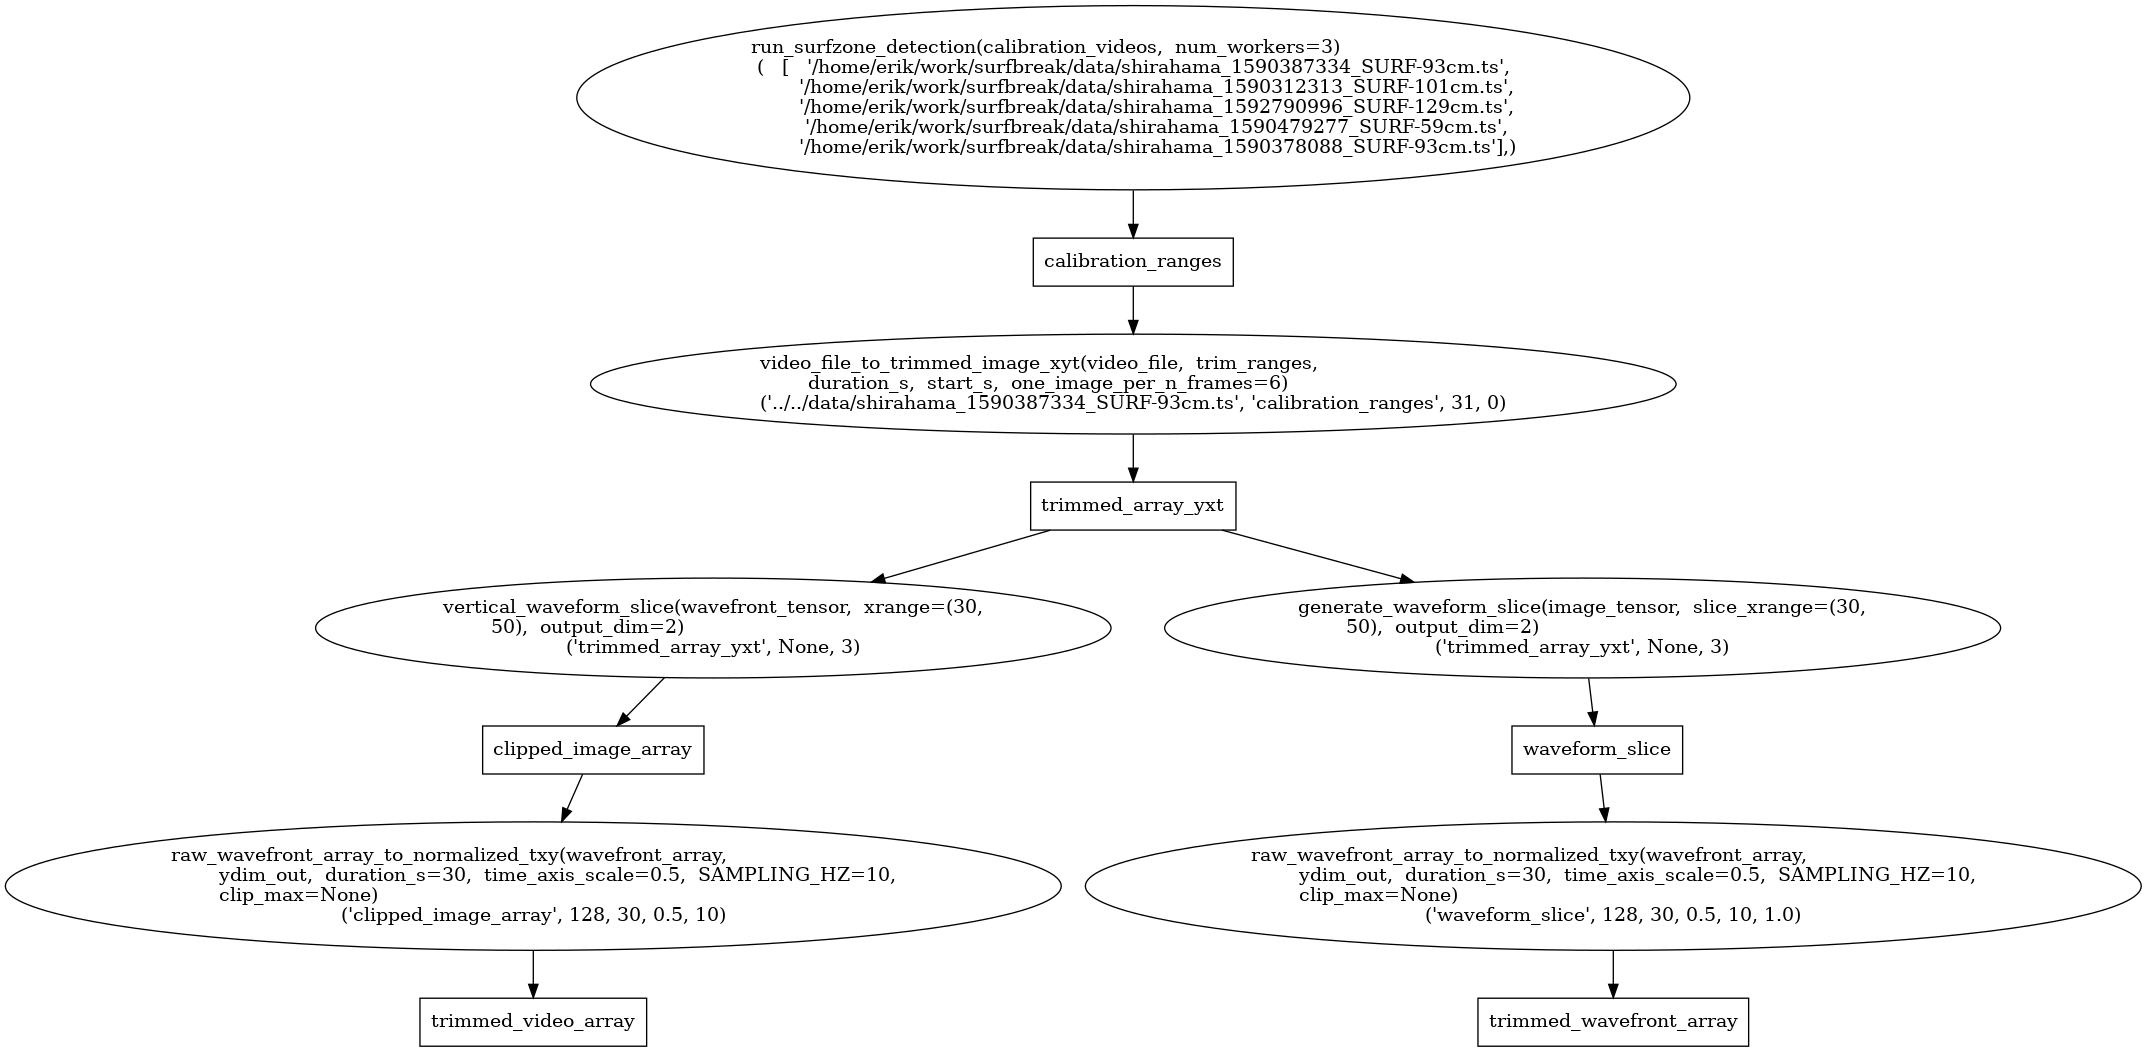

In [ ]:
from surfbreak.pipelines import video_to_waveform_array_txy
from surfbreak.graphutils import visualize
dask_graph = video_to_waveform_array_txy(video_filepath, ydim_out=128)
visualize(dask_graph, rankdir='UD')

(150, 1036, 128)


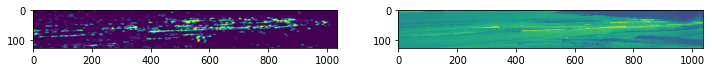

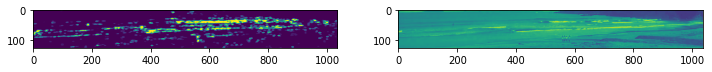

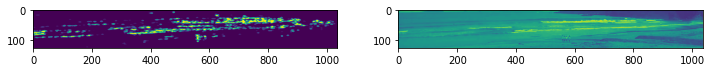

In [ ]:
import graphchain
import matplotlib.pyplot as plt
vid_array = graphchain.get(dask_graph, 'trimmed_video_array')
wavefront_array = graphchain.get(dask_graph, 'trimmed_wavefront_array')
print(vid_array.shape)
for t in range(3):
    fig, ax = plt.subplots(ncols=2, figsize=(12,3))
    ax[0].imshow(wavefront_array[t*5].T)
    ax[1].imshow(vid_array[t*5].T)
    plt.show()

In [ ]:
import torch
import pytorch_lightning as pl
from surfbreak.waveform_models import WaveformNet
from surfbreak.datasets import CachedDataset
from surfbreak.datasets import MaskedWavefrontDataset, WavefrontSupervisionDataset

training_video = '../../data/shirahama_1590387334_SURF-93cm.ts'
max_epochs=20
wf_net_kwargs = dict(
    hidden_features=256,
    hidden_layers=3,
    first_omega_0=2.5,
    hidden_omega_0=11,
    squared_slowness=1.0, #0.2
    learning_rate=1e-4,
    wavefunc_loss_scale=1e-12, #5.5e-9,
    wavespeed_loss_scale=1e-15, #4e-4, 
    wavespeed_first_omega_0=1.0, #3.5, 
    wavespeed_hidden_omega_0=2.0, #15, 
)

txy_cache = CachedDataset(WavefrontSupervisionDataset, training_video,
                          timerange=(0,2*60), time_chunk_duration_s=1, time_chunk_stride_s=1)
wf_train_dataset = MaskedWavefrontDataset(txy_cache,samples_per_batch=1000, included_time_fraction=1.0)
wf_valid_dataset = MaskedWavefrontDataset(txy_cache,samples_per_batch=1000, included_time_fraction=1.0)
viz_txy_dataset = WavefrontSupervisionDataset(training_video, timerange=(0,60), 
                                              time_chunk_duration_s=30, time_chunk_stride_s=30)

wavefunc_model = WaveformNet(train_dataset=wf_train_dataset, valid_dataset=wf_valid_dataset,
                             viz_dataset=viz_txy_dataset, batch_size=64,
                             **wf_net_kwargs)

tb_logger = pl.loggers.TensorBoardLogger('logs/', name="wfnet")
trainer = pl.Trainer(logger=tb_logger, limit_val_batches=30,
                     max_epochs=max_epochs, # 20 
                     gpus=1 if torch.cuda.is_available() else None,
                     track_grad_norm=2)

pl.seed_everything(42)
trainer.fit(wavefunc_model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type  | Params | In sizes     | Out sizes                   
---------------------------------------------------------------------------------------
0 | model          | Siren | 198 K  | [1, 1337, 3] | [[1, 1337, 1], [1, 1337, 3]]
1 | slowness_model | Siren | 8 K    | ?            | ?                           


1

## Optimize via optuna

In [ ]:
import os
import torch
import pytorch_lightning as pl
from optuna.integration import PyTorchLightningPruningCallback
from surfbreak.studies import run_waveform_hyperparam_search, MetricsCallback

from surfbreak.waveform_models import WaveformNet
from surfbreak.datasets import CachedDataset
from surfbreak.datasets import MaskedWavefrontDataset, WavefrontSupervisionDataset

LOGDIR = 'logs'
MODELDIR = os.path.join(LOGDIR, 'opt_models')

def objective(trial):
    
    checkpoint_callback = pl.callbacks.ModelCheckpoint( # Filenames for each trial must be made unique
        os.path.join(MODELDIR, "trial_{}".format(trial.number), "{epoch}"), monitor="val_loss")
    tb_logger = pl.loggers.TensorBoardLogger(LOGDIR+'/', name="optuna")
    metrics_callback = MetricsCallback()     # Simple callback that saves metrics from each validation step.
    pl.seed_everything(42)

    
    training_video = '../../data/shirahama_1590387334_SURF-93cm.ts'
    max_epochs=10
    wf_net_kwargs = dict(
        hidden_features=256,
        hidden_layers=3,
        first_omega_0=trial.suggest_uniform('first_omega_0', 0.5, 3.5), #1.5, 
        hidden_omega_0=trial.suggest_uniform('hidden_omega_0', 8.5, 15), #11.7,
        squared_slowness=trial.suggest_uniform('squared_slowness', 0.20, 4), #0.23,
        learning_rate=5e-5, 
        wavefunc_loss_scale=trial.suggest_loguniform('wavefunc_loss_scale', 5e-10, 5e-8), #2e-8,
        wavespeed_loss_scale=trial.suggest_loguniform('wavespeed_loss_scale', 1e-4, 1e-2), #1e-3
        wavespeed_first_omega_0=trial.suggest_uniform('wavespeed_first_omega_0',1.0,6.0), #3.5, 
        wavespeed_hidden_omega_0=trial.suggest_uniform('wavespeed_hidden_omega_0',5,30), #15, 
    )

    txy_cache = CachedDataset(WavefrontSupervisionDataset, training_video,
                              timerange=(0,2*60), time_chunk_duration_s=1, time_chunk_stride_s=1)
    wf_train_dataset = MaskedWavefrontDataset(txy_cache,samples_per_batch=1000, included_time_fraction=1.0)
    wf_valid_dataset = MaskedWavefrontDataset(txy_cache,samples_per_batch=1000, included_time_fraction=1.0)
    viz_txy_dataset = WavefrontSupervisionDataset(training_video, timerange=(0,60), 
                                                  time_chunk_duration_s=30, time_chunk_stride_s=30)

    wavefunc_model = WaveformNet(train_dataset=wf_train_dataset, valid_dataset=wf_valid_dataset,
                                 viz_dataset=viz_txy_dataset, batch_size=64,
                                 **wf_net_kwargs)

    trainer = pl.Trainer(logger=tb_logger, limit_val_batches=50,
                         max_epochs=max_epochs, # 20 
                         gpus=1 if torch.cuda.is_available() else None,
                         callbacks=[metrics_callback],
                         early_stop_callback=PyTorchLightningPruningCallback(trial, monitor="val_loss"),
                        )
    trainer.fit(wavefunc_model)
    
    return metrics_callback.metrics[-1]["val_loss"].item()


study = run_waveform_hyperparam_search(objective, n_trials=100, timeout=8*60*60, model_dir=MODELDIR, 
                                       prune=True, n_startup_trials=3, n_warmup_steps=5)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type  | Params | In sizes     | Out sizes                   
---------------------------------------------------------------------------------------
0 | model          | Siren | 198 K  | [1, 1337, 3] | [[1, 1337, 1], [1, 1337, 3]]
1 | slowness_model | Siren | 8 K    | ?            | ?                           


[I 2020-07-19 18:11:12,762] Finished trial#0 with value: 0.21486926078796387 with parameters: {'first_omega_0': 2.6859506330673137, 'hidden_omega_0': 14.40264007257526, 'squared_slowness': 1.179620869123157, 'wavefunc_loss_scale': 9.836149752344652e-10, 'wavespeed_loss_scale': 0.002440197981525788, 'wavespeed_first_omega_0': 4.366316541666123, 'wavespeed_hidden_omega_0': 28.803897166872893}. Best is trial#0 with value: 0.21486926078796387.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type  | Params | In sizes     | Out sizes                   
---------------------------------------------------------------------------------------
0 | model          | Siren | 198 K  | [1, 1337, 3] | [[1, 1337, 1], [1, 1337, 3]]
1 | slowness_model | Siren | 8 K    | ?            | ?                           


[I 2020-07-19 19:15:00,043] Finished trial#1 with value: 0.25670337677001953 with parameters: {'first_omega_0': 2.7520928035233707, 'hidden_omega_0': 9.137168952931614, 'squared_slowness': 2.0925543708691, 'wavefunc_loss_scale': 3.387464086038555e-09, 'wavespeed_loss_scale': 0.005772867654471713, 'wavespeed_first_omega_0': 5.218623114407158, 'wavespeed_hidden_omega_0': 14.283926507792101}. Best is trial#0 with value: 0.21486926078796387.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type  | Params | In sizes     | Out sizes                   
---------------------------------------------------------------------------------------
0 | model          | Siren | 198 K  | [1, 1337, 3] | [[1, 1337, 1], [1, 1337, 3]]
1 | slowness_model | Siren | 8 K    | ?            | ?                           


[I 2020-07-19 20:20:20,172] Finished trial#2 with value: 0.260935515165329 with parameters: {'first_omega_0': 2.0380177825354195, 'hidden_omega_0': 10.036365529995827, 'squared_slowness': 2.917053397803187, 'wavefunc_loss_scale': 3.971012672392388e-09, 'wavespeed_loss_scale': 0.0025265202879204618, 'wavespeed_first_omega_0': 3.219688449468254, 'wavespeed_hidden_omega_0': 22.86961873578572}. Best is trial#0 with value: 0.21486926078796387.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type  | Params | In sizes     | Out sizes                   
---------------------------------------------------------------------------------------
0 | model          | Siren | 198 K  | [1, 1337, 3] | [[1, 1337, 1], [1, 1337, 3]]
1 | slowness_model | Siren | 8 K    | ?            | ?                           


[I 2020-07-19 21:21:43,439] Finished trial#3 with value: 0.25796765089035034 with parameters: {'first_omega_0': 1.0814395048724776, 'hidden_omega_0': 9.255866102314224, 'squared_slowness': 1.9923794320049386, 'wavefunc_loss_scale': 2.8520693493211927e-09, 'wavespeed_loss_scale': 0.009013196274669778, 'wavespeed_first_omega_0': 2.329726749947457, 'wavespeed_hidden_omega_0': 22.458213823413143}. Best is trial#0 with value: 0.21486926078796387.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type  | Params | In sizes     | Out sizes                   
---------------------------------------------------------------------------------------
0 | model          | Siren | 198 K  | [1, 1337, 3] | [[1, 1337, 1], [1, 1337, 3]]
1 | slowness_model | Siren | 8 K    | ?            | ?                           


[I 2020-07-19 22:23:48,119] Finished trial#4 with value: 0.2415899932384491 with parameters: {'first_omega_0': 2.606260182892822, 'hidden_omega_0': 14.377863754350425, 'squared_slowness': 2.395339402031798, 'wavefunc_loss_scale': 3.6807365175170346e-09, 'wavespeed_loss_scale': 0.0001154011317139665, 'wavespeed_first_omega_0': 4.58194521241945, 'wavespeed_hidden_omega_0': 13.983233179997644}. Best is trial#0 with value: 0.21486926078796387.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type  | Params | In sizes     | Out sizes                   
---------------------------------------------------------------------------------------
0 | model          | Siren | 198 K  | [1, 1337, 3] | [[1, 1337, 1], [1, 1337, 3]]
1 | slowness_model | Siren | 8 K    | ?            | ?                           


[I 2020-07-19 23:27:08,514] Finished trial#5 with value: 0.25297844409942627 with parameters: {'first_omega_0': 3.0618702559863866, 'hidden_omega_0': 10.879033916523554, 'squared_slowness': 3.5391432976508788, 'wavefunc_loss_scale': 3.048191873663123e-09, 'wavespeed_loss_scale': 0.00913977551509893, 'wavespeed_first_omega_0': 2.266797483215971, 'wavespeed_hidden_omega_0': 8.444396799933857}. Best is trial#0 with value: 0.21486926078796387.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type  | Params | In sizes     | Out sizes                   
---------------------------------------------------------------------------------------
0 | model          | Siren | 198 K  | [1, 1337, 3] | [[1, 1337, 1], [1, 1337, 3]]
1 | slowness_model | Siren | 8 K    | ?            | ?                           


[I 2020-07-20 00:29:46,508] Finished trial#6 with value: 0.27178269624710083 with parameters: {'first_omega_0': 2.6589344089786175, 'hidden_omega_0': 11.807553910280458, 'squared_slowness': 2.5610365059315177, 'wavefunc_loss_scale': 7.978213942428174e-09, 'wavespeed_loss_scale': 0.004949195076748426, 'wavespeed_first_omega_0': 1.3252069499796073, 'wavespeed_hidden_omega_0': 11.906765996672407}. Best is trial#0 with value: 0.21486926078796387.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type  | Params | In sizes     | Out sizes                   
---------------------------------------------------------------------------------------
0 | model          | Siren | 198 K  | [1, 1337, 3] | [[1, 1337, 1], [1, 1337, 3]]
1 | slowness_model | Siren | 8 K    | ?            | ?                           


[I 2020-07-20 01:30:38,778] Finished trial#7 with value: 0.22171013057231903 with parameters: {'first_omega_0': 1.3106398186719295, 'hidden_omega_0': 10.315150939540612, 'squared_slowness': 3.1716972984130942, 'wavefunc_loss_scale': 5.351636410605043e-10, 'wavespeed_loss_scale': 0.0017774855529817963, 'wavespeed_first_omega_0': 5.41292353661704, 'wavespeed_hidden_omega_0': 29.48043565237387}. Best is trial#0 with value: 0.21486926078796387.


Number of finished trials: 8
Best trial was #0:
  Value: 0.21486926078796387
  Params: 
    first_omega_0: 2.6859506330673137
    hidden_omega_0: 14.40264007257526
    squared_slowness: 1.179620869123157
    wavefunc_loss_scale: 9.836149752344652e-10
    wavespeed_loss_scale: 0.002440197981525788
    wavespeed_first_omega_0: 4.366316541666123
    wavespeed_hidden_omega_0: 28.803897166872893
